In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mlflow pymysql

In [5]:
from drive.MyDrive.PCO.function import *
import pandas as pd

<h2><span style="background-color:grey; color:white; padding: 5px;">Choix des paramètres pour l'entraînement, le stockage sur MLflow et des données à récupérer.</span></h2>

In [6]:
#//////////////////////////////////////////////////////////////////////////////
#                       Option de filtrage des données
#//////////////////////////////////////////////////////////////////////////////
# Variable permettant de choisir si on veut traiter les outliers
gestion_outliers =True

# Nombre de ventes minimum sur une commune pour calculer un prix moyen au m² par commune
nb_ventes_mini = 10

# Taux de filtrage :
# - Le premier élément est le nombre de vente minimum par commune
# - Le deuxième élément est le pourcentage de outliers dans une commune
#
# Exemple pour tx_filtrage =[10,30] les lignes qui seront conservées seront :
# Les communes dans lesquelles il restera minimum 10 ventes après suppression des outliers
# ET  moins de 30% d'outliers
# ET les lignes inférieures à la limite des outliers
# tx_filtrage = [0,100] => Suppression des lignes dont le montant est au dessus de la limite des outliers.
tx_filtrage =[nb_ventes_mini,30]

# Recherche sur une région spécifique si recherche sur toute la France mettre ''
region=''

# Recherche sur un type de bien spécifique si recherche sur tous les bien mettre ''
type_de_bien =''

# Inclure la surface du terrain True ou False
surface_terrain = True

# Nombre de mois pour l'entraînement et le test (train=80% test= 20%)
# Exemple si 15 mois environ 12 mois pour l'entraînement et 3 mois pour le test
# Mettre None pour utiliser toutes les données disponible
nb_mois=30

#*******************  Pour ajouter d'autres variables :  ***********************
#*********  modifier la requête dans la fonction construcion_requete() *********


#//////////////////////////////////////////////////////////////////////////////
#                       Configuration de mlfow
#//////////////////////////////////////////////////////////////////////////////
# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "Tensorflow"

# runs à effectuer all_datas 15months all_datas_surface_terrain 15months_surface_terrain)
# run_name = f"{region}_{'Appartement_Maison' if len(type_de_bien)==0 else type_de_bien}"\
#     f"_{nb_mois}months_GridSearch_GestionOutliers_{'oui' if gestion_outliers==True else 'non'}"\
#     f"_{'' if surface_terrain==False else 'surface_terrain'}"
run_name ="NameRegion_NameTypeBien_Appt_Maison_GestionOutliersOui_SurfaceTerrainOui_30Mois"
model_name = f"TFK_{run_name}"

<h2><span style="background-color:grey; color:white; padding: 5px;">Création de la requête </span></h2>


In [7]:
where_clause, query = construcion_requete(region,
                        type_de_bien,
                        nb_ventes_mini,
                        surface_terrain,
                        nb_mois)
print(query)


    # Table pour compter le nombre de ventes par commune
    WITH nb_ventes_mini AS(
    SELECT
        ID_COMMUNE AS ID_COMMUNE,
        count(*) nb_ventes_par_commune
    FROM VENTES 
    WHERE DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 30 MONTH)
    GROUP BY ID_COMMUNE
    )

    # Selection des variables voulues pour l'entraînement du modèle
    SELECT 
        V.SURFACE_BATI,
        V.ID_COMMUNE,
        V.DATE_MUTATION,
        T.NAME_TYPE_BIEN,
        R.Name_region,
        V.SURFACE_TERRAIN,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE R.Name_region NOT IN('Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Guadeloupe')  AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 30 MONT

<h2><span style="background-color:grey; color:white; padding: 5px;">Chargement des données et suppression des outliers. </span></h2>

In [8]:
df = loading_data(query)

if gestion_outliers==True:
    df=filtrage(df,tx_filtrage,where_clause)

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Il y a 23205 communes avec plus de 10 ventes avant suppression des outliers, pour un total de 2406641 ventes
Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok


,ID_COMMUNE,nb_outliers,total_ventes,ventes_restantes,NAME_COMMUNE,pourcentage_ventes_retirees
0,33063,2591,14245,11654,Bordeaux,18.19
1,92012,2185,5056,2871,Boulogne-Billancourt,43.22
2,06088,2105,22827,20722,Nice,9.22
3,92051,1969,2731,762,Neuilly-sur-Seine,72.10
4,44109,1620,16226,14606,Nantes,9.98
5,31555,1481,24005,22524,Toulouse,6.17
6,06029,1466,7787,6321,Cannes,18.83
7,92044,1277,2914,1637,Levallois-Perret,43.82
8,78646,1231,3017,1786,Versailles,40.80
9,94068,1200,3524,2324,Saint-Maur-des-Fossés,34.05


Nombre d'outliers : 142947
Nombre de commune avec des outliers : 8574
Nombre de communes contenant des outliers et pour lesquels ilreste plus de 10 ventes après suppression des outliers : 7811
Nombre de communes avec plus de 30% de ventes retirées : 508
Nombre de communes qui seront retirées : 1105
Nombre de ventes restantes après suppression des outlier et après filtrage : 2205382
Il y a donc eu 8.36% de lignes supprimées après filtrage


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement du modèle et stockage des données avec MLflow. </span></h2>

Split des données en cours...


/content/drive/MyDrive/PCO/function.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DATE_MUTATION'] = pd.to_datetime(df['DATE_MUTATION'])
/content/drive/MyDrive/PCO/function.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
Normalisation des données en cours...
Normalisation des données OK
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13783/13783 [==============================] - 175s 13ms/step - lo

2024/02/17 15:41:35 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/02/17 15:42:38 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/10/ebb4a9280fc846c1a219f8f4b1b0f4c8/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'TFK_NameRegion_NameTypeBien_Appt_Maison_GestionOutliersOu

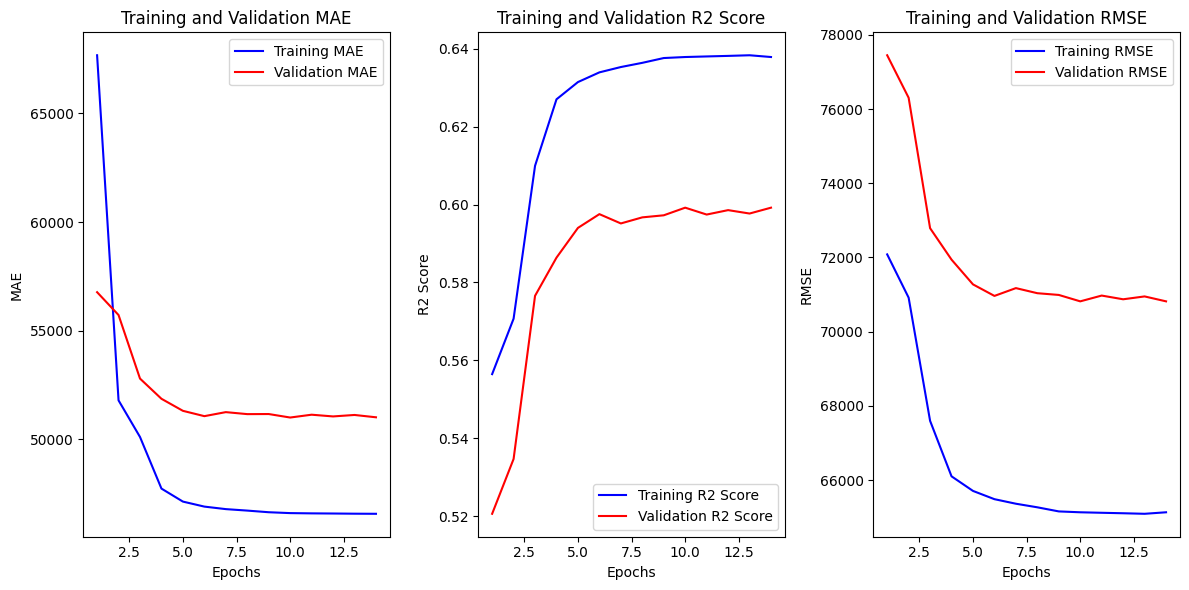

In [9]:
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, image_path = train_tensor_flow(X_train,y_train,X_test,y_test)

param_mlflow(uri_tracking=uri_tracking,
        experiment_name=experiment_name, run_name=run_name,
        model=model, model_name=model_name,
        X_test=X_test, y_test=y_test,
        encoders=encoders,scalers=scalers,
        images = [image_path]).log_mlflow()